# Connection

In [1]:
!pip install sqlalchemy
!pip install python-dotenv
!pip install psycopg2

In [2]:
# libraries
import pandas as pd
import sqlalchemy as sa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [5]:
import os
from dotenv import load_dotenv

load_dotenv()

traveltide_database = os.getenv("DATABASE_URL")

In [4]:
# database engine and connection execution
engine = sa.create_engine(traveltide_database)
connection = engine.connect().execution_options(isolation_level = "AUTOCOMMIT")

# DB Schema

*Sessions: flight and hotel discount columns are actually booleans.*

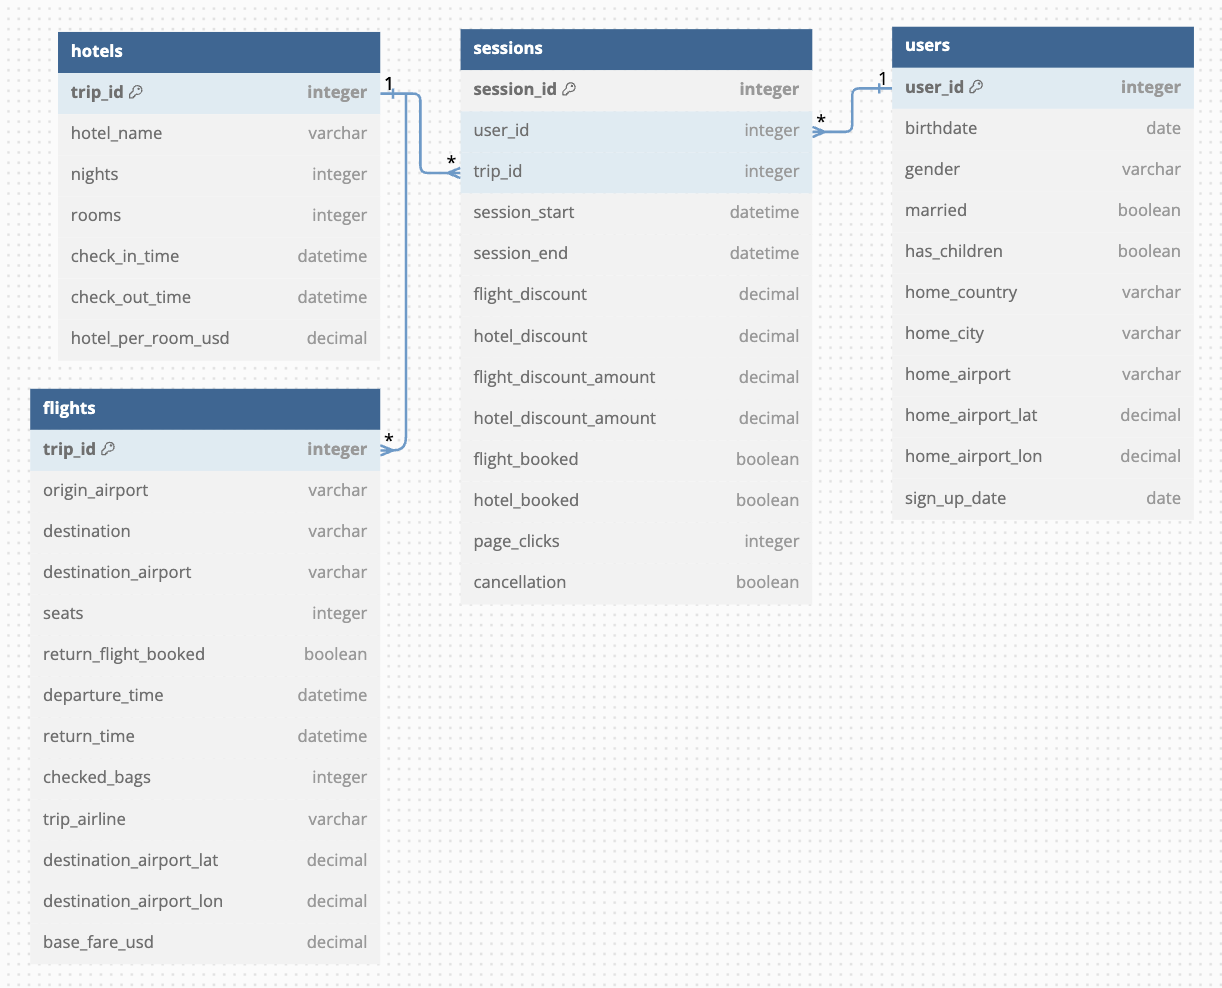

# EDA

## Data Structure


In [ ]:
#data base overview
query = """
SELECT *
FROM information_schema.tables
WHERE table_schema = 'public'

"""
pd.read_sql(sa.text(query),connection)

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,TravelTide,public,sessions,BASE TABLE,None,None,None,None,None,YES,NO,None
1,TravelTide,public,flights,BASE TABLE,None,None,None,None,None,YES,NO,None
2,TravelTide,public,users,BASE TABLE,None,None,None,None,None,YES,NO,None
3,TravelTide,public,hotels,BASE TABLE,None,None,None,None,None,YES,NO,None


In [ ]:
#preparing tables
users = pd.read_sql_table('users',connection)
hotels = pd.read_sql_table('hotels',connection)
flights = pd.read_sql_table('flights',connection)
sessions = pd.read_sql_table('sessions',connection)

In [ ]:
#table size
print(f'Users: {users.shape}')
print(f'Hotels: {hotels.shape}')
print(f'Flights: {flights.shape}')
print(f'Sessions: {sessions.shape}')


Users: (1020926, 11)
Hotels: (1918617, 7)
Flights: (1901038, 13)
Sessions: (5408063, 13)


## Data types

In [ ]:
# users
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020926 entries, 0 to 1020925
Data columns (total 11 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1020926 non-null  int64         
 1   birthdate         1020926 non-null  datetime64[ns]
 2   gender            1020926 non-null  object        
 3   married           1020926 non-null  bool          
 4   has_children      1020926 non-null  bool          
 5   home_country      1020926 non-null  object        
 6   home_city         1020926 non-null  object        
 7   home_airport      1020926 non-null  object        
 8   home_airport_lat  1020926 non-null  float64       
 9   home_airport_lon  1020926 non-null  float64       
 10  sign_up_date      1020926 non-null  datetime64[ns]
dtypes: bool(2), datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 72.0+ MB


In [ ]:
# hotels
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1918617 entries, 0 to 1918616
Data columns (total 7 columns):
 #   Column              Dtype         
---  ------              -----         
 0   trip_id             object        
 1   hotel_name          object        
 2   nights              int64         
 3   rooms               int64         
 4   check_in_time       datetime64[ns]
 5   check_out_time      datetime64[ns]
 6   hotel_per_room_usd  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(2)
memory usage: 102.5+ MB


In [ ]:
# flights
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1901038 entries, 0 to 1901037
Data columns (total 13 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   trip_id                  object        
 1   origin_airport           object        
 2   destination              object        
 3   destination_airport      object        
 4   seats                    int64         
 5   return_flight_booked     bool          
 6   departure_time           datetime64[ns]
 7   return_time              datetime64[ns]
 8   checked_bags             int64         
 9   trip_airline             object        
 10  destination_airport_lat  float64       
 11  destination_airport_lon  float64       
 12  base_fare_usd            float64       
dtypes: bool(1), datetime64[ns](2), float64(3), int64(2), object(5)
memory usage: 175.9+ MB


In [ ]:
# sessions
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5408063 entries, 0 to 5408062
Data columns (total 13 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   session_id              object        
 1   user_id                 int64         
 2   trip_id                 object        
 3   session_start           datetime64[ns]
 4   session_end             datetime64[ns]
 5   flight_discount         bool          
 6   hotel_discount          bool          
 7   flight_discount_amount  float64       
 8   hotel_discount_amount   float64       
 9   flight_booked           bool          
 10  hotel_booked            bool          
 11  page_clicks             int64         
 12  cancellation            bool          
dtypes: bool(5), datetime64[ns](2), float64(2), int64(2), object(2)
memory usage: 355.9+ MB


## Data Quality Check

### Missing Data

In [ ]:
#checking for nulls
print('Users:')
print(users.isnull().sum())
print('\nHotels:')
print(hotels.isnull().sum())
print('\nFlights:')
print(flights.isnull().sum())
print('\nSessions:')
print(sessions.isnull().sum())

Users:
user_id             0
birthdate           0
gender              0
married             0
has_children        0
home_country        0
home_city           0
home_airport        0
home_airport_lat    0
home_airport_lon    0
sign_up_date        0
dtype: int64

Hotels:
trip_id               0
hotel_name            0
nights                0
rooms                 0
check_in_time         0
check_out_time        0
hotel_per_room_usd    0
dtype: int64

Flights:
trip_id                        0
origin_airport                 0
destination                    0
destination_airport            0
seats                          0
return_flight_booked           0
departure_time                 0
return_time                88734
checked_bags                   0
trip_airline                   0
destination_airport_lat        0
destination_airport_lon        0
base_fare_usd                  0
dtype: int64

Sessions:
session_id                      0
user_id                         0
trip_id          

In [ ]:
#one more look at missing data
print('Flights:')
missing_data_flights = pd.DataFrame({
    'Total Missing': flights.isnull().sum(),
    'Percentage': round(flights.isnull().mean() * 100,2)
})
print(missing_data_flights)

print('\nSessions:')
missing_data_sessions = pd.DataFrame({
    'Total Missing': sessions.isnull().sum(),
    'Percentage': round(sessions.isnull().mean() * 100,2)
})
print(missing_data_sessions)

Flights:
                         Total Missing  Percentage
trip_id                              0        0.00
origin_airport                       0        0.00
destination                          0        0.00
destination_airport                  0        0.00
seats                                0        0.00
return_flight_booked                 0        0.00
departure_time                       0        0.00
return_time                      88734        4.67
checked_bags                         0        0.00
trip_airline                         0        0.00
destination_airport_lat              0        0.00
destination_airport_lon              0        0.00
base_fare_usd                        0        0.00

Sessions:
                        Total Missing  Percentage
session_id                          0        0.00
user_id                             0        0.00
trip_id                       3072218       56.81
session_start                       0        0.00
session_end     

### Missing Data: conclusion

*   Nulls in **return_time** mean that return flight was not booked
*   Nulls in **flight** and **hotel discount amount** mean that no discount was provided
*  Nulls in **trip_id** mean that session has ended without booking a flight/hotel
* Hence, these **nulls don't need any handling**

---

 **43% of sessions end with booking a trip**

  * This indicates that nearly half of the sessions on
TravelTide result in a booking. This is a strong conversion rate, suggesting that the platform is effective in encouraging users to complete bookings once they engage with it.
  * However, there is room for improvement since 57% of sessions do not result in a booking. Strategies to convert a higher percentage of these sessions into bookings could be beneficial.

---

**16% of users get flight discount &**
**13% of users get hotel discount**

  * Given the relatively low percentages of users receiving discounts, implementing a more robust and personalized rewards program could help in increasing engagement and retention.


### Data Anomalies

In [ ]:
# users
query = """
SELECT *
FROM users
WHERE EXTRACT(YEAR FROM AGE(birthdate)) < 0
   OR EXTRACT(YEAR FROM AGE(birthdate)) > 120
   OR birthdate > CURRENT_DATE
   OR gender NOT IN ('M', 'F', 'O')
   OR sign_up_date < birthdate
;
"""
pd.read_sql(sa.text(query),connection)

,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,home_airport_lon,sign_up_date


In [ ]:
# hotels
query = """
SELECT *
FROM hotels
WHERE nights < 1
   OR rooms < 1
   OR check_in_time > check_out_time
   OR hotel_per_room_USD < 0
;
"""
pd.read_sql(sa.text(query),connection)

,trip_id,hotel_name,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,449200-01513254b25b4c688561f2a56eb9ebdb,Aman Resorts - austin,0,1,2022-12-22 19:31:52.230,2022-12-23 11:00:00,77.0
1,449242-95cff988a0884f9b89cda6c5c081042b,Starwood - san francisco,0,1,2022-12-21 16:42:41.040,2022-12-22 11:00:00,133.0
2,449885-e2abcb6eed1048649de0a9a52a90932e,Best Western - los angeles,0,1,2022-12-22 19:43:23.340,2022-12-23 11:00:00,86.0
3,449968-f711b9e92bc64a35985d1f9ed18a52e7,Crowne Plaza - san diego,0,1,2022-12-23 12:31:09.390,2022-12-24 11:00:00,125.0
4,452010-292afa5435574670b61064dcb792a34e,Fairmont - houston,0,2,2022-12-24 12:19:37.290,2022-12-25 11:00:00,39.0
...,...,...,...,...,...,...,...
152052,444271-e342e05d732d4be3a085305450f89201,Hyatt - dallas,0,2,2022-12-25 10:09:15.525,2022-12-25 11:00:00,133.0
152053,446975-20a4d5ac6c794fc5b543d4cfa666ea7b,Aman Resorts - philadelphia,0,1,2022-12-25 13:49:13.530,2022-12-26 11:00:00,303.0
152054,447263-e2a950628ee84f4597aeba19c62d08d5,Accor - austin,0,1,2022-12-28 13:38:32.325,2022-12-29 11:00:00,96.0
152055,447855-e0a3aefe52b341418397d0a6786f0769,Conrad - new york,0,2,2022-12-21 13:56:32.595,2022-12-22 11:00:00,248.0


In [ ]:
# flights
query = """
SELECT *
FROM flights
WHERE origin_airport = destination_airport
   OR seats < 0
   OR base_fare_USD < 0
   OR (return_flight_booked = 'true' AND return_time IS NULL)
   OR (return_flight_booked = 'false' AND return_time IS NOT NULL)
;
"""
pd.read_sql(sa.text(query),connection)

,trip_id,origin_airport,destination,destination_airport,seats,return_flight_booked,departure_time,return_time,checked_bags,trip_airline,destination_airport_lat,destination_airport_lon,base_fare_usd


In [ ]:
# sessions
query = """
SELECT *
FROM sessions
WHERE session_start > session_end
   OR (hotel_discount = 'true' AND (hotel_discount_amount IS NULL OR hotel_discount_amount < 0) AND cancellation = 'false')
   OR (flight_discount = 'true' AND (flight_discount_amount IS NULL OR flight_discount_amount < 0) AND cancellation = 'false')
   OR page_clicks < 0
;
"""
pd.read_sql(sa.text(query),connection)

,session_id,user_id,trip_id,session_start,session_end,flight_discount,hotel_discount,flight_discount_amount,hotel_discount_amount,flight_booked,hotel_booked,page_clicks,cancellation


### Data Anomalies: conclusion

*   **Users**: no anomalies
*   **Hotels:** anomalies due to errors in check in/out times
*   **Flights:** no anomalies
*   **Sessions:** no anomalies


---
Anomalies in **Hotels** should be explored and fixed/dropped




### Hotels: handling anomalies

In [ ]:
# according to stakeholders, any value of 0/-1 in 'nights' column corresponds to 1 night.
query = """
SELECT trip_id, hotel_name,
       CASE WHEN nights < 1 THEN 1
       ELSE nights
       END AS nights,
       check_in_time, check_out_time, hotel_per_room_usd

FROM hotels
LIMIT 10;
"""
pd.read_sql(sa.text(query),connection)

,trip_id,hotel_name,nights,check_in_time,check_out_time,hotel_per_room_usd
0,448827-5287ba78cc97442fb8f8c8116b38197d,Aman Resorts - los angeles,2,2022-12-24 13:19:17.715,2022-12-27 11:00:00,215.0
1,448837-d83fb11ee5dd4bbda71ab2b3890a5a28,Best Western - san jose,8,2022-12-19 11:00:00.000,2022-12-27 11:00:00,232.0
2,448855-3ed41c7dfc304acab033ec610f0b75eb,Hyatt - milwaukee,9,2022-12-23 10:21:06.750,2023-01-01 11:00:00,67.0
3,448879-2623b4a6b24f4bf39e6a5af97ee9c775,Aman Resorts - el paso,1,2022-12-23 11:58:32.565,2022-12-24 11:00:00,94.0
4,449059-9c6923212a13416a9aa33c0e4563e879,Accor - fresno,9,2022-12-31 11:00:00.000,2023-01-09 11:00:00,80.0
5,449122-ec8c940a181041ca84228a557924de7c,Radisson - montreal,2,2022-12-23 12:12:57.285,2022-12-26 11:00:00,296.0
6,449162-90238bb942664d91920f94f203bed32b,Four Seasons - houston,6,2022-12-26 11:00:00.000,2023-01-01 11:00:00,300.0
7,449169-95ea38bb78d6469e98c142134099d523,Hilton - san antonio,14,2022-12-23 16:11:40.110,2023-01-07 11:00:00,106.0
8,449200-01513254b25b4c688561f2a56eb9ebdb,Aman Resorts - austin,1,2022-12-22 19:31:52.230,2022-12-23 11:00:00,77.0
9,449213-8c599b07e1e4410c88e662d31ab526d7,Conrad - boston,3,2022-12-21 11:34:47.280,2022-12-24 11:00:00,92.0


# Data Preprocessing

## Defining the Cohort

In [ ]:
# Initial Extraction Query
# users with more then 7 sessions after April 1, 2023 (acc. to suggestion of head of marketing)
query = """

WITH target_cohort AS (
    SELECT user_id
    FROM sessions
    WHERE session_start > '2023-01-04'
    GROUP BY user_id
    HAVING COUNT(session_id) > 7
)

SELECT
    s.user_id,
    u.gender,
    EXTRACT(YEAR FROM AGE(u.birthdate)) AS age,
    u.married,
    u.has_children,
    u.home_airport,
    u.home_city,
    u.home_country,
    s.session_id,
    s.session_start,
    s.session_end,
    (s.session_end - s.session_start) AS session_duration,
    s.page_clicks,
    s.trip_id,
    s.flight_booked,
    s.hotel_booked,
    s.flight_discount,
    s.flight_discount_amount,
    s.hotel_discount,
    s.hotel_discount_amount,
    s.cancellation,
    f.origin_airport,
    f.destination AS destination_city,
    f.destination_airport,
    f.seats,
    f.return_flight_booked,
    f.departure_time,
    f.return_time,
    f.checked_bags,
    f.trip_airline,
    f.base_fare_usd,
    h.hotel_name,
    CASE WHEN h.nights < 1 THEN 1
         ELSE h.nights
    END AS nights, -- Handling anomalies like -1/0 nights
    h.rooms,
    h.check_in_time,
    h.check_out_time,
    h.hotel_per_room_usd,
    -- total spent per trip
    COALESCE(f.base_fare_usd, 0) * COALESCE(f.seats, 1) AS total_flight_spent,
    COALESCE(h.hotel_per_room_usd, 0) * COALESCE(h.rooms, 1) * CASE WHEN h.nights < 1 THEN 1 ELSE h.nights END AS total_hotel_spent,
    COALESCE(f.base_fare_usd, 0) * COALESCE(f.seats, 1) + COALESCE(h.hotel_per_room_usd, 0) * COALESCE(h.rooms, 1) * CASE WHEN h.nights < 1 THEN 1 ELSE h.nights END AS total_spent,
    -- flight distance, rounded to 2 decimal places
    ROUND(
        6371 * ACOS(
            COS(RADIANS(u.home_airport_lat)) * COS(RADIANS(f.destination_airport_lat)) *
            COS(RADIANS(f.destination_airport_lon) - RADIANS(u.home_airport_lon)) +
            SIN(RADIANS(u.home_airport_lat)) * SIN(RADIANS(f.destination_airport_lat))
        )::Numeric,
        2
    ) AS flight_distance_km,
    (EXTRACT(EPOCH FROM (s.session_end - s.session_start)) / 60) AS session_duration_mins

FROM target_cohort tc
JOIN sessions s ON tc.user_id = s.user_id
JOIN users u ON s.user_id = u.user_id
LEFT JOIN flights f ON s.trip_id = f.trip_id
LEFT JOIN hotels h ON s.trip_id = h.trip_id

WHERE s.session_start > '2023-01-04';

"""
#saving to use with python
connection = sa.create_engine(traveltide_database)
target_cohort = pd.read_sql(sa.text(query), connection)


## Outliers handling

In [ ]:
# IQR percentile outlier detection function
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.05)
    Q3 = df[column].quantile(0.95)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

# convertion of session_duration to minutes if the column exists
if 'session_duration' in target_cohort.columns:
    target_cohort['session_duration_mins'] = round(target_cohort['session_duration'].dt.total_seconds() / 60, 2)

# identification of numerical columns
numerical_columns = target_cohort.select_dtypes(include=['number']).columns

# empty list to collect outlier dataframes
outliers_list = []

# application of IQR-based outlier detection to each numerical column
for col in numerical_columns:
    column_outliers = detect_outliers_iqr(target_cohort, col)
    if not column_outliers.empty:
        outliers_list.append(column_outliers)

# concatenation of all detected outliers and duplicates removal
if outliers_list:
    outliers = pd.concat(outliers_list).drop_duplicates()
else:
    outliers = pd.DataFrame()  # Empty DataFrame if no outliers were detected

# printing outliers
print(f"Number of outliers detected: {len(outliers)}")


# removing outliers from the dataset
target_cohort_cleaned = target_cohort.drop(outliers.index, errors='ignore')

# printing the shape of the cleaned dataset
print(f"Original dataset shape: {target_cohort.shape}")
print(f"Cleaned dataset shape: {target_cohort_cleaned.shape}")

# saving the cleaned dataset to CSV
target_cohort_cleaned.to_csv('target_cohort_cleaned.csv', index=False)


Number of outliers detected: 2090
Original dataset shape: (49211, 42)
Cleaned dataset shape: (47121, 42)


In [ ]:
# replacement of NaNs with zeros in numerical columns
numeric_columns = [col for col in target_cohort_cleaned.select_dtypes(include=['float64', 'int64']).columns \
                   if col not in ['user_id', 'session_id','trip_id']]

for col in numeric_columns:
    if col in target_cohort_cleaned.columns:
        target_cohort_cleaned[col].fillna(0, inplace=True)

# replacement NaNs with 'Unknown' in categorical columns (excluding datetime columns)
categorical_columns = target_cohort_cleaned.select_dtypes(include=['object']).columns

for col in categorical_columns:
    target_cohort_cleaned[col].fillna('Unknown', inplace=True)

# replacement NaNs in datetime columns with pd.NaT
datetime_columns = target_cohort_cleaned.select_dtypes(include=['datetime64[ns]']).columns

for col in datetime_columns:
    target_cohort_cleaned[col].fillna(pd.NaT, inplace=True)

# printing the updated DF
print(target_cohort_cleaned.head())


   user_id gender   age  married  has_children home_airport home_city  \
0   437251      F  43.0    False         False          YXU    london   
1   371201      M  28.0    False          True          JFK  new york   
2   371201      M  28.0    False          True          JFK  new york   
3   371201      M  28.0    False          True          JFK  new york   
4   371201      M  28.0    False          True          JFK  new york   

  home_country                               session_id       session_start  \
0       canada  437251-377469be34e94ee083aeac4af3a77534 2023-03-03 15:31:00   
1          usa  371201-3894eb55b0054c838bb0203599ec7e05 2023-04-14 20:32:00   
2          usa  371201-965f11e3515c43dbac5683ea389ee380 2023-03-22 16:18:00   
3          usa  371201-1a26d44351e44dd28d7a129d303daa9d 2023-01-19 08:08:00   
4          usa  371201-24752e3b602946268687703ca55aad6c 2023-01-10 11:10:00   

   ... nights rooms           check_in_time      check_out_time  \
0  ...    2.0   1.0

## Preprocessing for boolean values

In [ ]:
#converting booleans to 1/0

#getting all columns with boolean values
booleans = [col for col in target_cohort_cleaned.select_dtypes('boolean').columns]

#converting booleans to 0 and 1
target_cohort_cleaned[booleans] = target_cohort_cleaned[booleans].astype(int)

print(target_cohort_cleaned[booleans])

       married  has_children  flight_booked  hotel_booked  flight_discount  \
0            0             0              1             1                0   
1            0             1              0             0                0   
2            0             1              0             0                0   
3            0             1              0             0                1   
4            0             1              0             0                0   
...        ...           ...            ...           ...              ...   
49206        0             0              1             1                0   
49207        0             0              1             1                0   
49208        0             0              1             0                0   
49209        1             1              1             1                0   
49210        1             0              1             1                1   

       hotel_discount  cancellation  
0                   0    

In [ ]:
print(target_cohort_cleaned['session_id'].nunique())
print(target_cohort_cleaned['trip_id'].nunique())

47121
14749


## User-level Aggregation

In [ ]:
# aggregating user-level features

user_level_df = target_cohort_cleaned.groupby('user_id').agg({
    'gender': 'first',
    'age': 'first',
    'married': 'first',
    'has_children': 'first',
    'home_airport': 'first',
    'session_duration_mins': 'sum',
    'page_clicks': 'sum',
    'flight_booked': 'sum',
    'hotel_booked': 'sum',
    'flight_discount': 'sum',
    'flight_discount_amount': 'mean',
    'hotel_discount': 'sum',
    'hotel_discount_amount': 'mean',
    'cancellation': 'sum',
    'seats': 'sum',
    'checked_bags': 'sum',
    'base_fare_usd': 'mean',
    'nights': 'sum',
    'rooms': 'sum',
    'hotel_per_room_usd': 'mean',
    'flight_distance_km': 'mean',
    'trip_id': 'nunique',
    'session_id': 'nunique'
}).reset_index()

# printing the dataframe
print(user_level_df.head())

   user_id gender   age  married  has_children home_airport  \
0   181157      F  54.0        1             0          HOU   
1   182191      F  19.0        0             1          PHX   
2   187212      F  55.0        1             1          LAX   
3   189676      F  36.0        0             1          FTW   
4   190866      F  37.0        0             0          TLH   

   session_duration_mins  page_clicks  flight_booked  hotel_booked  ...  \
0                  13.57          110              2             2  ...   
1                   8.43           68              0             0  ...   
2                  15.84          128              3             3  ...   
3                   8.09           65              0             1  ...   
4                  23.08          186              5             5  ...   

   cancellation  seats  checked_bags  base_fare_usd  nights  rooms  \
0             0    2.0           1.0      71.914286     3.0    2.0   
1             0    0.0        

In [ ]:
# creating additional metrics

# proportion of flights and hotels with discounts applied
user_level_df['discounted_flight_proportion'] = (user_level_df['flight_discount'] / user_level_df['flight_booked'])
user_level_df['discounted_hotel_proportion'] = (user_level_df['hotel_discount'] / user_level_df['hotel_booked'])

# proportion of bookings with checked bags
user_level_df['checked_bags_proportion'] = (user_level_df['checked_bags']/user_level_df['flight_booked'])

# bargain hunter index
user_level_df['bargain_hunter_index'] = (user_level_df['discounted_hotel_proportion'] + user_level_df['discounted_flight_proportion'])/2

# hotel booked proportion
user_level_df['hotel_booked_proportion'] = (user_level_df['hotel_booked'] / user_level_df['trip_id'])

# flight booked proportin
user_level_df['flight_booked_proportion'] = (user_level_df['flight_booked'] / user_level_df['trip_id'])

# cancellation rate (num of cancellations / num of trips)
user_level_df['cancellation_rate'] = (user_level_df['cancellation'] / user_level_df['trip_id'])

# booking rate (num of trips / num of sessions)
user_level_df['booking_rate'] = (user_level_df['trip_id'] / user_level_df['session_id'])

# average flight distance
user_level_df['avg_flight_distance'] = user_level_df['flight_distance_km']/user_level_df['flight_booked']


In [ ]:
# rounding to 2 decimal places and fixing created NaNs and inf
user_level_df = user_level_df.round(2)
user_level_df.replace([np.inf, -np.inf], np.nan, inplace=True)
user_level_df.fillna(0, inplace=True)

# printing the first 5 rows
print(user_level_df.head())

# saving the DataFrame to CSV
user_level_df.to_csv('user_level_table.csv', index=False)

   user_id gender   age  married  has_children home_airport  \
0   181157      F  54.0        1             0          HOU   
1   182191      F  19.0        0             1          PHX   
2   187212      F  55.0        1             1          LAX   
3   189676      F  36.0        0             1          FTW   
4   190866      F  37.0        0             0          TLH   

   session_duration_mins  page_clicks  flight_booked  hotel_booked  ...  \
0                  13.57          110              2             2  ...   
1                   8.43           68              0             0  ...   
2                  15.84          128              3             3  ...   
3                   8.09           65              0             1  ...   
4                  23.08          186              5             5  ...   

   session_id  discounted_flight_proportion  discounted_hotel_proportion  \
0           7                          0.50                         0.50   
1           7     

# Perks assignement

According to the suggestion of the head of marketing, we should implement the following perks in out loyalty program:

* **Free Hotel Meal**

* **1 Night Free Hotel with Flight**

* **Exclusive Discounts**

* **Free Checked Bag**

* **No Cancellation Fee**

## K-Means Approach

In [ ]:
# converting gender column data type to numbers
gender_mapping = {
    'F': 0,  # Female
    'M': 1,  # Male
    'O': 2   # Other
}

user_level_df['gender'] = user_level_df['gender'].map(gender_mapping)

# checking that everything worked as supposed
print(user_level_df['gender'].value_counts())

gender
0    5274
1     695
2      11
Name: count, dtype: int64


In [ ]:
# columns for clustering
features = [
    'age', 'session_duration_mins', 'page_clicks', 'flight_booked', 'hotel_booked',
    'flight_discount_amount', 'hotel_discount_amount', 'seats', 'checked_bags',
    'base_fare_usd', 'nights', 'rooms', 'hotel_per_room_usd', 'avg_flight_distance',
    'discounted_flight_proportion', 'discounted_hotel_proportion', 'checked_bags_proportion',
    'bargain_hunter_index', 'hotel_booked_proportion', 'flight_booked_proportion',
    'cancellation_rate', 'booking_rate'
]

X = user_level_df[features]

# standardization of numerical values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# elbow method for num of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

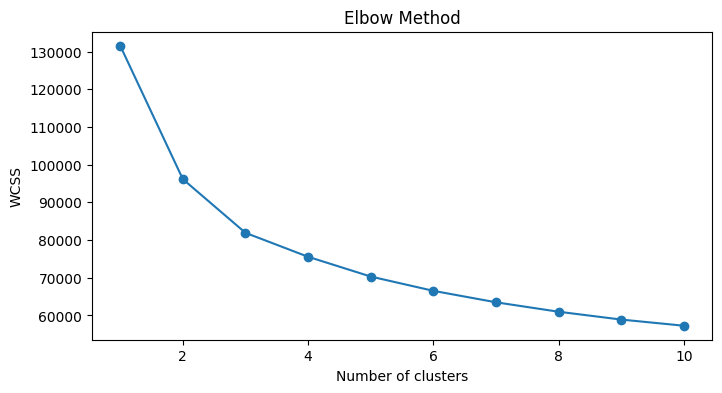

The chart clearly shows an "elbow" at the **3-cluster mark**, indicating that 3 clusters could be optimal for balancing simplicity and effectiveness. However, for a more granular segmentation, I prefer to use 5 clusters, which aligns well with our 5 perks and allows for more targeted marketing strategies.

In [ ]:
# KMeans with the optimal number of clusters
optimal_clusters = 4  # number adjusted to 4 after further review
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
user_level_df['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluate clustering
print(f'Silhouette Score: {silhouette_score(X_scaled, user_level_df["cluster"])}')

Silhouette Score: 0.17588982950659843


The **Silhouette Score of 0.175** indicates relatively weak clustering, which can be attributed to the complexity of human nature. People's preferences and behaviors are diverse and multifaceted, making it difficult to distinctly group them into sharply defined clusters.

In [ ]:
# including only relevant columns
columns_to_include = ['age', 'gender', 'has_children', 'married', 'session_duration_mins', 'page_clicks', 'flight_booked', 'hotel_booked',
                      'flight_discount', 'flight_discount_amount', 'hotel_discount', 'hotel_discount_amount',
                      'seats', 'checked_bags', 'base_fare_usd', 'nights', 'rooms', 'hotel_per_room_usd',
                      'flight_distance_km', 'discounted_flight_proportion', 'discounted_hotel_proportion',
                      'checked_bags_proportion', 'bargain_hunter_index', 'hotel_booked_proportion',
                      'flight_booked_proportion', 'cancellation_rate', 'booking_rate', 'cluster']

# filtering to include only these columns
filtered_df = user_level_df[columns_to_include]

# getting mean values for each cluster
cluster_summary = filtered_df.groupby('cluster').mean()

# number of users in each cluster
cluster_counts = user_level_df['cluster'].value_counts().sort_index()
pd.set_option('display.max_columns', None)

# printing cluster summary and counts
print(cluster_summary)
print(cluster_counts)


               age    gender  has_children   married  session_duration_mins  \
cluster                                                                       
0        43.745647  0.113806      0.268035  0.419776              19.485597   
1        39.210854  0.106762      0.342527  0.397687              11.390854   
2        42.543946  0.122422      0.343946  0.461883              14.646771   
3        40.986248  0.138507      0.361493  0.472495              13.449381   

         page_clicks  flight_booked  hotel_booked  flight_discount  \
cluster                                                              
0         156.343905       3.835199      3.939677         1.273010   
1          91.669039       0.134342      0.484875         1.254448   
2         117.909417       2.160090      2.214350         1.113004   
3         107.939096       1.331041      1.403733         2.102161   

         flight_discount_amount  hotel_discount  hotel_discount_amount  \
cluster                       

After experimenting with 5 clusters, one of the clusters included only 25 users. From a marketing standpoint, it likely **doesn't make sense to maintain a cluster of just 25 users**. A more effective approach is to absorb these users into larger, more meaningful groups. This will simplify operations, enhance marketing efficiency, and allow for a stronger focus on perks with broader appeal and higher engagement potential.

**Therefore, I will move forward with 4 clusters and, accordingly, 4 perks.**

**UPD:** 4 clusters give more even distribution of users and I will stick to this approach.

In [ ]:
# viz of clusters
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_level_df['cluster']

plt.figure(figsize=(8, 4))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='tab10', s=100)
plt.title('Cluster Visualization')
plt.show()

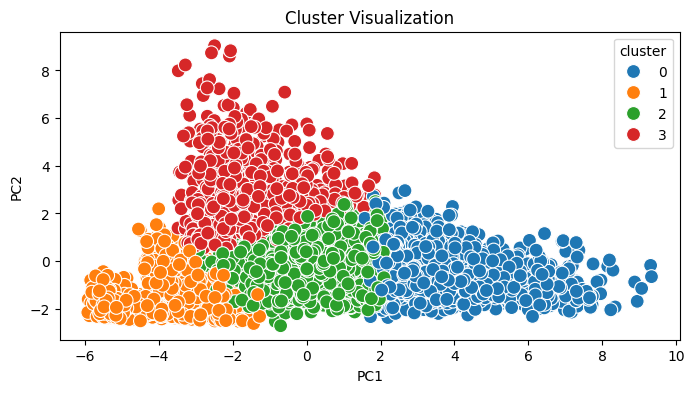

In [ ]:
#creating a heatmap to see correlations
metrics = [
    'checked_bags_proportion',
    'discounted_flight_proportion', 'discounted_hotel_proportion',
    'bargain_hunter_index', 'hotel_booked_proportion',
    'flight_booked_proportion', 'cancellation_rate', 'booking_rate'
]

# normalization
vmin = -1
vmax = 1

# DF with selected perks
filtered_summary = cluster_summary[metrics]

# transpose DF to swap x and y axes
transposed_summary = filtered_summary.T

# heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(transposed_summary, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=vmin, vmax=vmax)
plt.title('Cluster Characteristics Heatmap')
plt.xlabel('Clusters')
plt.ylabel('Metrics')
plt.show()



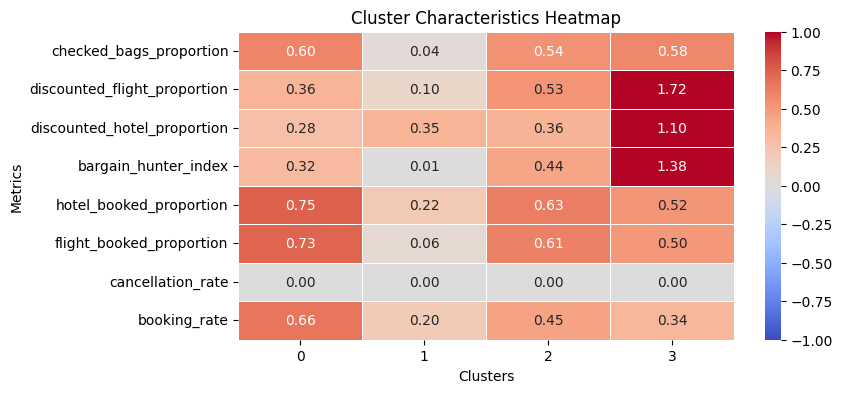

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plotting each perk with bar plots
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 12))
fig.suptitle('Metrics by Clusters', fontsize=14)

perks = ['session_duration_mins', 'page_clicks', 'checked_bags_proportion', 'discounted_flight_proportion',
         'discounted_hotel_proportion', 'bargain_hunter_index', 'hotel_booked_proportion',
         'flight_booked_proportion', 'cancellation_rate', 'booking_rate']

for i, perk in enumerate(perks):
    ax = axes[i // 2, i % 2]
    sns.barplot(x=cluster_summary.index, y=cluster_summary[perk], ax=ax, hue=cluster_summary.index, palette='tab10')
    ax.set_title(f'{perk.replace("_", " ").title()} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(perk.replace("_", " ").title())
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')
    ax.get_legend().remove()

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


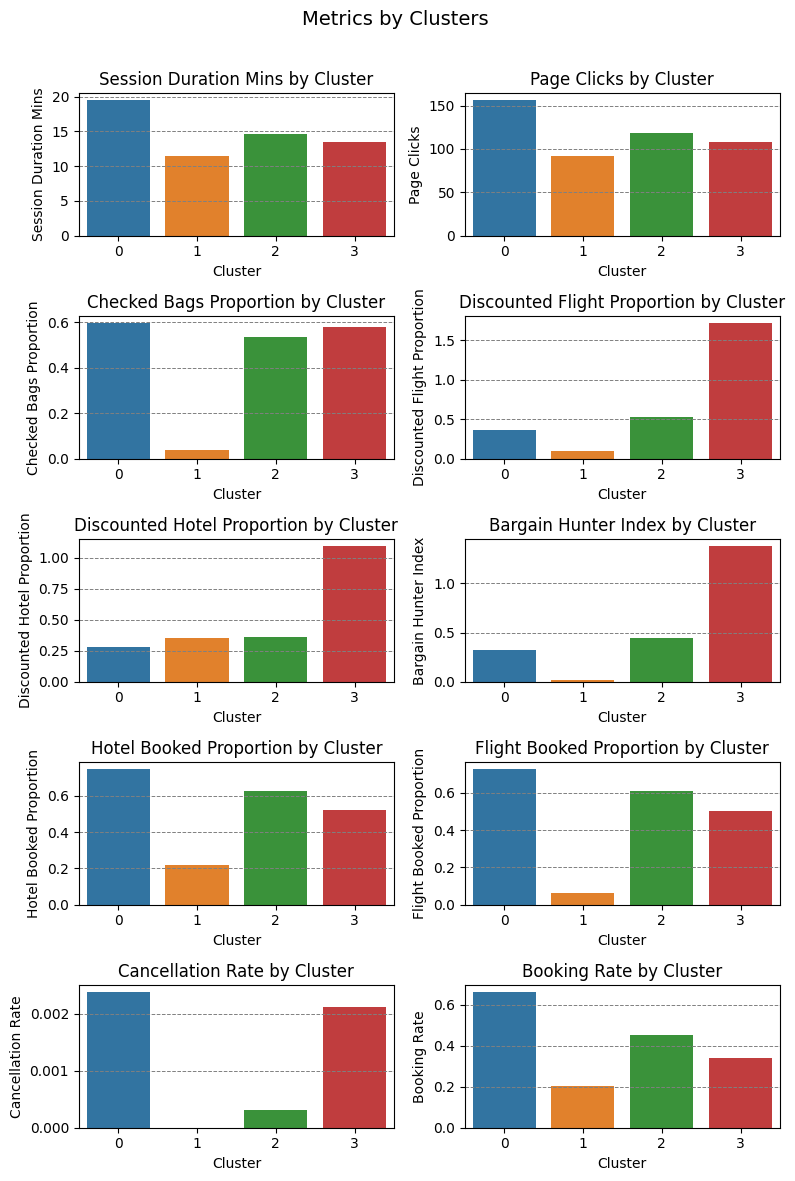

# Perk Mapping

### **Cluster 0 - Perk: Free Checked Bag**
- **Checked Bags Proportion:** 0.60 – High, indicating frequent use of checked baggage.
- **Hotel Booked Proportion:** 0.75 – High, indicating frequent hotel bookings.
- **Flight Booked Proportion:** 0.73 – High, indicating frequent flight bookings.
- **Booking Rate:** 0.66 – High, showing consistent engagement and booking activity.

**Why:** This cluster is highly engaged and likely consists of frequent travelers who value convenience. Offering a free checked bag can cater to their travel needs, making their frequent trips smoother and more cost-effective.

**Description:** Best for frequent travelers who are already heavily engaged. Enhancing their travel experience with added value, like a free checked bag, reinforces their loyalty.

### **Cluster 1 - Perk: No Cancellation Fee**
- **Hotel Booked Proportion:** 0.22 – Low, suggesting infrequent hotel bookings.
- **Flight Booked Proportion:** 0.06 – Extremely low, suggesting rare flight bookings.
- **Booking Rate:** 0.20 – Very low, indicating these users rarely complete bookings despite being in the app.

**Why:** Users in this cluster are cautious, booking infrequently, and may be risk-averse. Offering no cancellation fee could reduce their hesitations and encourage them to book more confidently.

**Description:** Best for low-engagement users who may be risk-averse. Reducing the penalty for cancellations can encourage more bookings from this cautious group.

### **Cluster 2 - Perk: 1 Night Free Hotel with Flight**
- **Hotel Booked Proportion:** 0.63 – Moderate, indicating regular hotel bookings.
- **Flight Booked Proportion:** 0.61 – Moderate, indicating regular flight bookings.
- **Booking Rate:** 0.45 – Moderate, suggesting regular engagement but with room for improvement.

**Why:** Users in this cluster are somewhat engaged and book both hotels and flights at a moderate rate. Offering a 1-night free hotel stay with flight booking could incentivize them to book more frequently and explore new destinations.

**Description:** Ideal for moderately engaged travelers who can be encouraged to book more frequently with value-added deals that enhance their overall travel experience.

### **Cluster 3 - Perk: Exclusive Discounts**
- **Discounted Flight Proportion:** 1.72 – Extremely high, indicating a strong preference for discounted flights.
- **Discounted Hotel Proportion:** 1.10 – High, indicating a strong preference for discounted hotels.
- **Bargain Hunter Index:** 1.38 – Very high, indicating a strong inclination towards finding the best deals.

**Why:** This cluster is highly price-sensitive and is actively seeking the best deals. Offering exclusive discounts on both flights and hotels will resonate well with their bargain-hunting behavior, making them more likely to book through your platform.

**Description:** Best for highly price-sensitive travelers who prioritize finding deals. Providing exclusive discounts will align with their values and keep them engaged on your platform.

These perks align well with the behavior and characteristics of each cluster, helping to maximize engagement and booking rates across different types of travelers.

The **"Free Hotel Meal" is less impactful** compared to other perks because it doesn't strongly align with the core behaviors or needs identified in the clusters. However, **it might still serve as a secondary perk for moderate-engagement travelers** who book hotels, potentially enhancing the perceived value of their stay.

In [ ]:
# perks mapping based on clusters
def assign_perk(cluster_id):
    if cluster_id == 0:
        return 'Free Checked Bags'
    elif cluster_id == 1:
        return 'No Cancellation Fee'
    elif cluster_id == 2:
        return '1 Night Free Hotel with Flight'
    elif cluster_id == 3:
        return 'Exclusive Discounts'
    else:
        return 'Unknown Perk'


user_level_df['perk'] = user_level_df['cluster'].apply(assign_perk)

# printing the updated DataFrame with perks
print(user_level_df['perk'].head())

# saving DF with perks assigned
user_level_df.to_csv('user_level_with_perks.csv', index=False)

0    1 Night Free Hotel with Flight
1               No Cancellation Fee
2    1 Night Free Hotel with Flight
3               No Cancellation Fee
4                 Free Checked Bags
Name: perk, dtype: object


In [ ]:
# num of user in each perk cluster
perk_counts = user_level_df['perk'].value_counts()

# tab10 colormap
colors = plt.get_cmap('tab10').colors

# pie chart
plt.figure(figsize=(6, 6))
plt.pie(perk_counts, labels=perk_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85, colors=colors)

# maaagic!
plt.tight_layout()
plt.title('Distribution of Users by Perk')
plt.show()


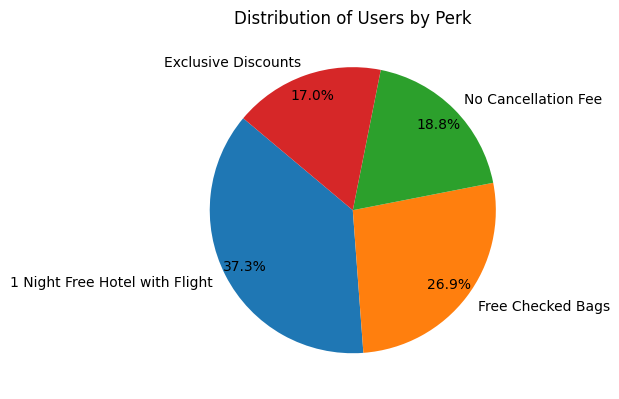

# Perk Distribution
**Free Checked Bag (26.9%)**
- **Target Audience**: Frequent travelers who regularly book flights and hotels.
- **Promotion Strategy**: Showcase the significant cost savings and convenience of this perk. Highlight how a free checked bag makes frequent travel more enjoyable and affordable. Use engaging ads and personalized emails to emphasize the ease and value this benefit brings to their travel experience.

**No Cancellation Fee (18.8%)**
- **Target Audience**: Cautious users with low booking engagement.
- **Promotion Strategy**: Promote this perk as a way to book with confidence. Stress the flexibility and peace of mind that come with no cancellation fees. Craft reassuring messages that encourage these users to overcome hesitation and make more bookings with reduced risk.

**1 Night Free Hotel with Flight (37.3%)**
- **Target Audience**: Moderately engaged travelers who book flights and hotels at a moderate rate.
- **Promotion Strategy**: Highlight the exceptional value of a free hotel night when booking a flight. Create enticing content and promotions that emphasize the added benefits of this perk, encouraging users to book more frequently and explore new destinations.

**Exclusive Discounts (17%)**
- **Target Audience**: Price-sensitive travelers with a strong preference for deals.
- **Promotion Strategy**: Focus on the attractive savings offered through exclusive discounts. Use dynamic pricing and limited-time offers to capture their attention. Promote these deals through targeted ads and social media to align with their deal-seeking behavior and keep them engaged.

By aligning promotional efforts with the unique needs of each user group, we can effectively enhance engagement and boost bookings across diverse traveler segments.

In [ ]:
# Set up the figure and axes for the dashboard
fig, axes = plt.subplots(2, 2, figsize=(15, 12))  # 2x2 grid for four plots

# Set the title for the entire dashboard
fig.suptitle('Demographic Data by Perk', fontsize=16)

# Define the demographic features you want to plot
demographic_features = ['age', 'gender', 'married', 'has_children']

# Create plots for each demographic feature
for i, feature in enumerate(demographic_features):
    ax = axes[i // 2, i % 2]  # Get the correct subplot

    if feature == 'age':
        # Plot age distribution by perk
        sns.barplot(x='age', y='perk', hue='perk', data=user_level_df, ax=ax, errorbar=None)
        ax.set_title('Average Age by Perk')
        ax.set_xlabel('Average Age')
        ax.set_ylabel('')
        ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')

    elif feature == 'gender':
        # Plot gender distribution by perk
        sns.countplot(y='perk', hue='gender', data=user_level_df, ax=ax, palette='tab10')
        ax.set_title('Gender Distribution by Perk')
        ax.set_xlabel('Count')
        ax.set_ylabel('')
        ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')
        ax.legend(title='Gender', labels=['Female', 'Male', 'Other'], loc='lower right')
    elif feature == 'married':
        # Plot marital status distribution by perk
        sns.countplot(y='perk', hue='married', data=user_level_df, ax=ax, palette='tab10')
        ax.set_title('Marital Status Distribution by Perk')
        ax.set_xlabel('Count')
        ax.set_ylabel('')
        ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')
        ax.legend(title='Married', labels=['No', 'Yes'], loc='lower right')
    elif feature == 'has_children':
        # Plot children status distribution by perk
        sns.countplot(y='perk', hue='has_children', data=user_level_df, ax=ax, palette='tab10')
        ax.set_title('Children Status Distribution by Perk')
        ax.set_xlabel('Count')
        ax.set_ylabel('')
        ax.xaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')
        ax.legend(title='Has Children', labels=['No', 'Yes'], loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the suptitle
plt.show()

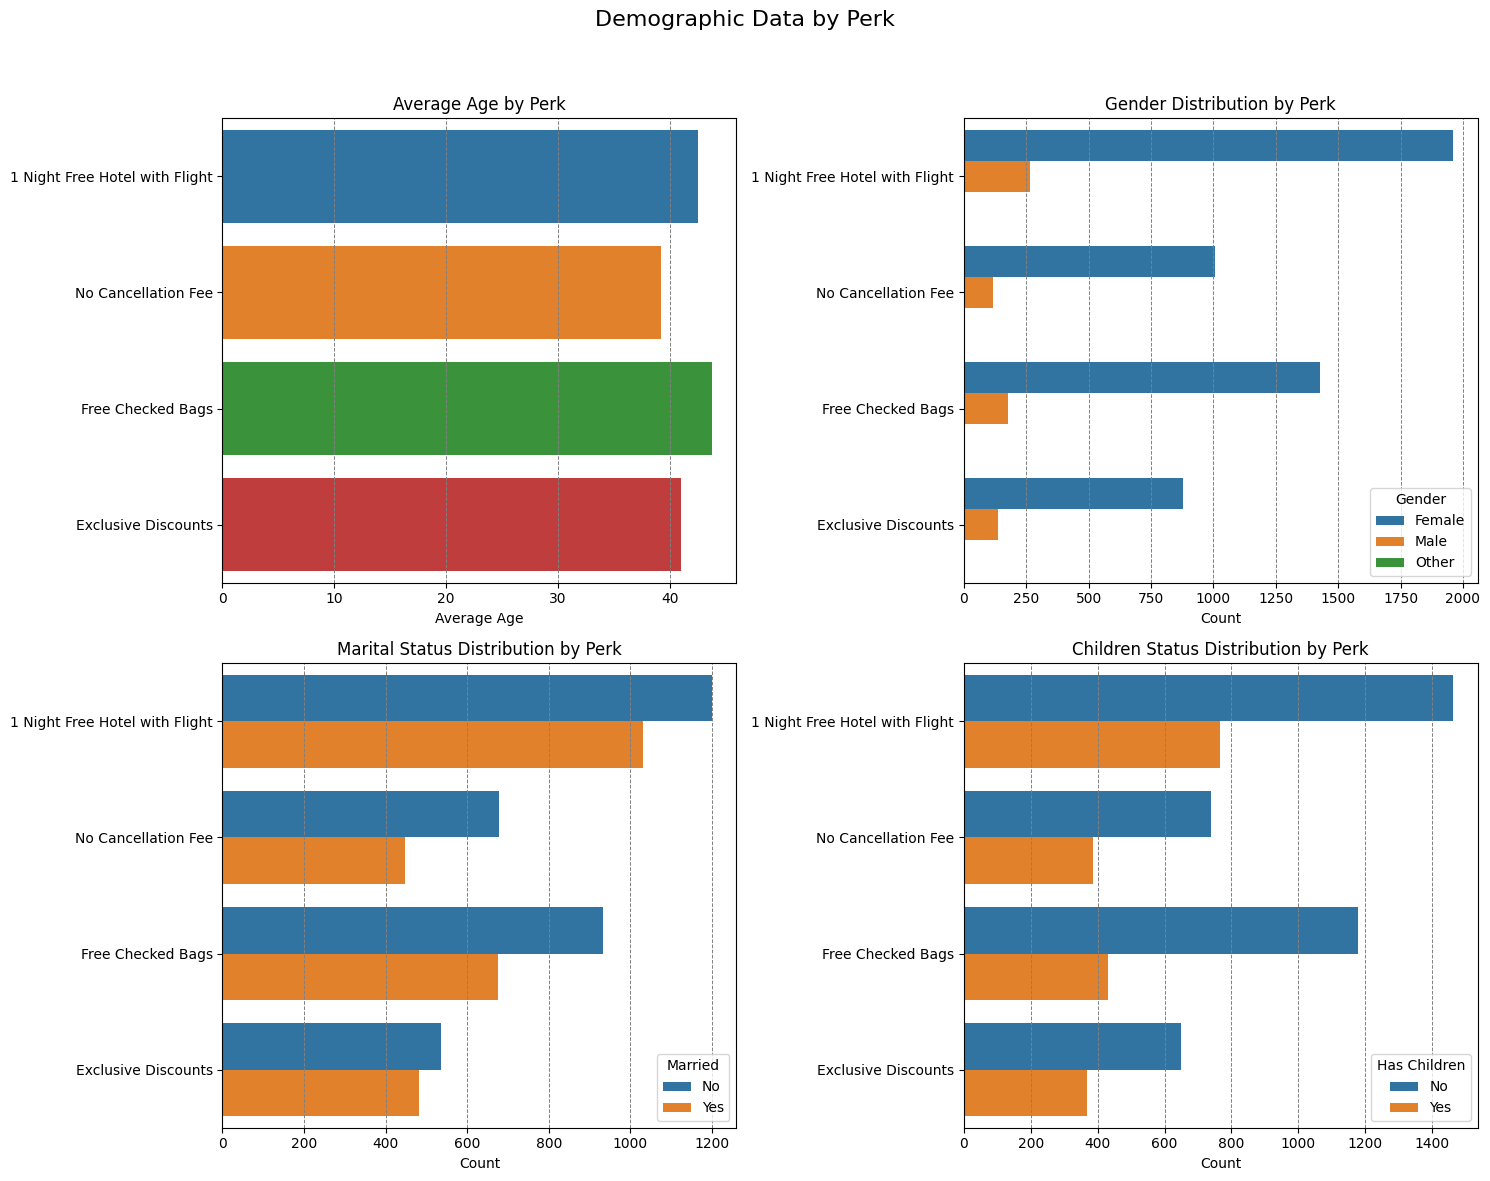

Across all perk groups, **female users are predominant**. Theoverall gender distribution shows that females make up 87.3% of the user base, while males account for 12.7%.

For the **"1 Night Free Hotel with Flight"** perk, the demographics reveal that the group includes a balanced mix of single and married travelers, with a higher proportion of users without children. The average age is 42.5 years.

In the **"Exclusive Discounts"** group, users are slightly younger, with more single travelers and a higher proportion without children. The average age of users in this category is 41 years.

The **"Free Checked Bags"** perk attracts a somewhat older demographic, with an average age of 43.7 years. This group also has a higher number of single travelers and a majority without children.

For the **"No Cancellation Fee"** perk, users are relatively younger, with an average age of 39.2 years. This group includes more single travelers and has a higher proportion of users without children.

Overall, while female users dominate across all categories, each perk group caters to specific demographic characteristics, influencing how they might best be marketed.

#Conclusions and Recommendations

### **Conclusions**

The analysis of user engagement and behaviors has provided valuable insights into the diverse preferences within our customer base. Here's an overview of the key findings:

1. **User Engagement and Behavior**: The segmentation reveals varied engagement levels among users, with significant differences in booking frequency, preference for perks, and overall activity on the platform. Users fall into distinct groups based on their travel habits and responses to promotional offers. The Silhouette Score of 0.175, while indicating some challenges in achieving perfect clustering due to the complexity of human preferences, still highlights clear patterns that can be leveraged for targeted marketing.

2. **Cluster Distribution and Preferences**:
   - **Cluster 0 (Free Checked Bag)**: This group represents highly engaged travelers who frequently book flights and hotels. They value practical benefits like a free checked bag that enhances their travel experience by reducing costs and improving convenience.
   - **Cluster 1 (No Cancellation Fee)**: Users in this cluster are less engaged and exhibit a cautious booking behavior. They are more likely to book infrequently and are deterred by the potential for cancellation fees. Offering this perk addresses their concerns and could stimulate more frequent bookings.
   - **Cluster 2 (1 Night Free Hotel with Flight)**: Moderately engaged travelers fall into this cluster. They book flights and hotels at a steady rate, and the offer of a free hotel night with a flight aims to increase their booking frequency and encourage exploration of new destinations.
   - **Cluster 3 (Exclusive Discounts)**: This cluster is characterized by a high sensitivity to price and a strong inclination toward finding deals. Users here are driven by savings, making exclusive discounts an appealing offer that aligns with their bargain-hunting tendencies.

3. **Demographic Insights**: The data reveals a predominantly female user base (87.3%), with varying age ranges and marital statuses across different clusters. For example, users attracted by the "Free Checked Bag" perk tend to be slightly older and more frequently single, whereas those interested in "Exclusive Discounts" are somewhat younger and also single. These demographic patterns indicate that while female users dominate, their preferences vary significantly based on age and marital status.

4. **Cluster Size and Effectiveness**: The decision to use 4 clusters, despite the initial consideration of 3 or 5, has proven effective in balancing user distribution and operational simplicity. Smaller clusters with limited user bases (such as those with only 25 users) have been absorbed into larger groups to ensure more impactful and manageable marketing strategies.

Overall, the segmentation and demographic analysis suggest that targeted perks can enhance user engagement by addressing specific needs and preferences. Tailoring marketing strategies to these insights will enable more effective promotions and a stronger connection with users across different segments.

### **Recommendations**

1. **Tailor Perks to Cluster Needs**: Implement the recommended perks based on cluster preferences to maximize engagement. For instance, promote the "Free Checked Bag" heavily among frequent travelers, and offer "Exclusive Discounts" to price-sensitive users.

2. **Enhance Marketing Strategies**: Use demographic insights to refine marketing messages. Highlight practical benefits like free checked baggage for older users, and emphasize exclusive discounts for younger, deal-oriented travelers.

3. **Promote Flexibility for Risk-Averse Users**: For the "No Cancellation Fee" cluster, focus on messaging that reduces perceived risk and builds trust, encouraging hesitant users to book with greater confidence.

4. **Leverage the Free Hotel Night Offer**: Emphasize the value proposition of the "1 Night Free Hotel with Flight" perk to moderately engaged users. Create targeted campaigns to boost engagement and booking frequency within this group.

5. **Monitor and Adjust**: Continuously monitor the performance of each perk and adjust strategies based on user feedback and changing preferences. Regular analysis will help refine the approach and ensure continued alignment with user needs.

By implementing these recommendations, we can effectively enhance user engagement, optimize the loyalty program, and drive increased bookings across different traveler segments.